<a href="https://colab.research.google.com/github/weisds/Unsupervised-Marketing_Campaign/blob/main/Unsupervised_Marketing_Campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Objective
The objective in this study is to create a binary classifition model to predict if the customer will accept the offer in a marketing campaign or not. Also to understand what determines this end result by looking at the feature improtance of the model.

#Data
This dataset is from Kaggle called [Marketing Campaign](https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign). This data dataset contains 29 columns and 2240 rows, covering information around time the customer was with the company, average spending in different product, number web visits, etc. The target variable is Response, a binary column indicating whether the customer accepted the offer or not.


#EDA and Feature Engineering
In the section below, we first run a corrolation heatmap to see if there are patterns of clustering in the data. Then, we check for null values and replace them with the respective mean values. Next, we seperate the data by type, text or numeric. In each category, we removed categorical data as they are not useful in clustering analysis. In perticular, in this phase, we engineered the Tenure feature from the Dt_Customer feature to provide information on how long the customer is with the company. Following the feature engineering, we flushed out binary and categorical features in the numeric feature group by detecting the number of unique values in each feature. Anything that has less than 10 unique values were removed. Lastly, we ran histogram on the remaining features to visually detect features with outliers and used the 1.5 * IQR approach to set upper and lower fance to detect and remove outliers. In the modeling stage, MinMaxScaler will be applied to all training features.

In [ ]:
#@title EDA and cleaning
#@markdown <ol><li>Corrolation <li>Find and replace nulls</li><li>seperate categorical and numeric data</li> <li>One-hot and lable encode data</li> <li>finding and cleaning outliers</li</ol> 
#@markdown 
df = pd.read_csv('/content/drive/MyDrive/Coursera/Dataset/marketing_campaign.csv', sep=";")
df = df.drop(['ID'], axis=1)

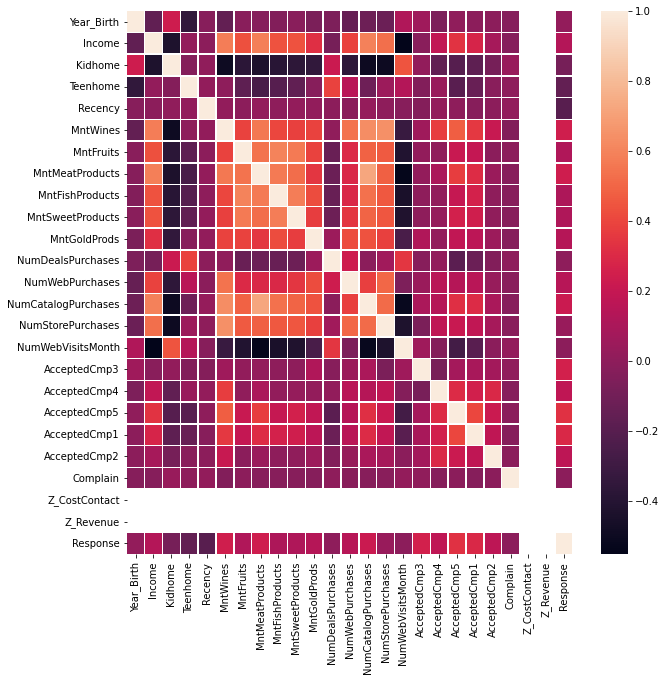

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(df.corr(), linewidths=.5)

We see some grouping (light amber tiles) around the amount spent on different products. Also, some negative corrolation between the number of web visits and different household types(with kid or teen). Thus, it is reasonable to anticipate good clustering in the later analysis

In [ ]:
#see nulls in the data, if any
df.isnull().sum()

Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [ ]:
#replace nulls with mean
df['Income'] = df['Income'].fillna(value=df['Income'].mean())

In [ ]:
#see data types to determine feature engineering tasks
df.dtypes.value_counts()

int64      24
object      3
float64     1
dtype: int64

In [ ]:
y = df.Response #using this to validate the unsupervised analysis results
X = df.drop(['Response'], axis=1)

#let split the data for more targeted handling
txt_cols = [cname for cname in X.columns if df[cname].dtype == "object"]

# Select numerical columns
num_cols = [cname for cname in X.columns if df[cname].dtype in ['int64', 'float64']]

In [ ]:
#determine categorical, binary, ordinal, and float data in numeric data
txt_uniques = pd.DataFrame([[i, len(X[i].unique()), X[i].unique()] for i in X[txt_cols]], columns=['Variable', 'number of Unique Values', 'Unique Values']).set_index('Variable')
txt_uniques

,number of Unique Values,Unique Values
Variable,,
Education,5,"[Graduation, PhD, Master, Basic, 2n Cycle]"
Marital_Status,8,"[Single, Together, Married, Divorced, Widow, A..."
Dt_Customer,663,"[2012-09-04, 2014-03-08, 2013-08-21, 2014-02-1..."


In [ ]:
#droping Marital_Status as it is categorical and no value in clustering
X=X.drop(['Marital_Status'], axis=1)

In [ ]:
#encode ordinal data
from sklearn.preprocessing import OrdinalEncoder
oen = OrdinalEncoder(categories=[['Basic','Graduation','2n Cycle', 'Master', 'PhD']])
X['Education'] = oen.fit_transform(X[['Education']])

In [ ]:
#engineering the tenure data from the datetime column
maxDate = pd.to_datetime(X.Dt_Customer).max()
tenure = maxDate - pd.to_datetime(X.Dt_Customer)
X['Tenure'] = tenure.dt.days
X = X.drop(['Dt_Customer'], axis=1)

In [ ]:
#get an overview of the numeric features with the goal to flush out discrete data
num_uniques = pd.DataFrame([[i, len(X[i].unique()), X[i].unique()] for i in X[num_cols]], columns=['Variable', 'number of Unique Values', 'Unique Values']).set_index('Variable')
num_uniques

,number of Unique Values,Unique Values
Variable,,
Year_Birth,59,"[1957, 1954, 1965, 1984, 1981, 1967, 1971, 198..."
Income,1975,"[58138.0, 46344.0, 71613.0, 26646.0, 58293.0, ..."
Kidhome,3,"[0, 1, 2]"
Teenhome,3,"[0, 1, 2]"
Recency,100,"[58, 38, 26, 94, 16, 34, 32, 19, 68, 11, 59, 8..."
MntWines,776,"[635, 11, 426, 173, 520, 235, 76, 14, 28, 5, 6..."
MntFruits,158,"[88, 1, 49, 4, 43, 42, 65, 10, 0, 5, 16, 61, 2..."
MntMeatProducts,558,"[546, 6, 127, 20, 118, 98, 164, 56, 24, 11, 48..."
MntFishProducts,182,"[172, 2, 111, 10, 46, 0, 50, 3, 1, 11, 225, 6,..."


In [ ]:
num_uniques = pd.DataFrame([[i, len(X[i].unique()), X[i].unique()] for i in X[num_cols]], columns=['Variable', 'number of Unique Values', 'Unique Values']).set_index('Variable')
dis_cols = num_uniques[num_uniques['number of Unique Values'] < 12].index
con_cols = num_uniques[num_uniques['number of Unique Values'] >= 12].index
X = X.drop(dis_cols, axis= 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd210e09c90>,
      dtype=object)

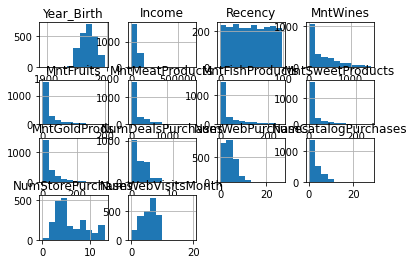

In [ ]:
#@title Identifying columns with outliers
X[con_cols].hist()

In [ ]:
con_cols

Index(['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'],
      dtype='object', name='Variable')

In [ ]:
#@title Romoving features with no outliers
no_outliers = ['Recency','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases']
num_variables_with_ol = con_cols.to_list()
for item in no_outliers:
  num_variables_with_ol.remove(item)

In [ ]:
#@title Using the 1.5 * IQR approach to create upper and lower fance to extract outliers
def outliers(df, ft):
  Q1 = df[ft].quantile(0.25)
  Q3 = df[ft].quantile(0.75)
  IQR = Q3 - Q1

  lower_b = Q1 - 1.5 * IQR
  uppper_b = Q3 + 1.5 * IQR
  ls = df.index[(df[ft] < lower_b) | (df[ft] > uppper_b)]
  return ls

In [ ]:
#removing outliers with index
from pandas._libs import index
index_list = []
for feature in num_variables_with_ol:
  index_list.extend(outliers(X, feature))

index_list = sorted(set(index_list))
X = X.drop(index_list)
y = y.drop(index_list)

X.shape[0] == y.shape[0]

True

#   Modeling and Conclusion
In this section, three clustering variations were attempted. The objective was to set the number of clusters to 2 for all the model variations to match the y column, which is the Response feature indicating if the customer accepted the offer or not. Then, we tested the clustering outcomes against the target feature to evaluate models. The criteria was essentially comparing the split between the 0s and 1s to see how well the predicting result matches with the target feature. Next, we tested Kmeans, AgglomerativeClustering with "ward" as the linkage parameter, and AgglomerativeClustering with "average" as the linkage parameter. In all three clustering models, the splits were close to 50/50, whereas the target feature split is close to 85/15, skewing toward the 0s. Therefore, we concluded that clustering is not a suitable modeling technique for this data. We recommand attempting other modeling techniques, such as classification. If clustering is the only avaliable option, based on this study, Kmeans would yeild slightly better results, 57/43 vs 55/45 with AgglomerativeClustering. 

In [ ]:
#fitting the data with kmeans and look at the result
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_s = pd.DataFrame(mms.fit_transform(X.values), columns=X.columns, index=X.index)

### BEGIN SOLUTION
km = KMeans(n_clusters=2, random_state=42)
km = km.fit(X_s)

X_s['kmeans'] = km.predict(X_s)

In [ ]:
df_clean = X_s.join(y)

(df_clean[['Response','kmeans']]
 .groupby(['kmeans','Response'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
kmeans Response        
0      0           1111
       1            120
1      0            746
       1            186

In [ ]:
X_s.kmeans.value_counts(normalize=True)

0    0.569117
1    0.430883
Name: kmeans, dtype: float64

In [ ]:
y.value_counts(normalize=True)

0    0.85853
1    0.14147
Name: Response, dtype: float64

In [ ]:
from sklearn.cluster import AgglomerativeClustering
### BEGIN SOLUTION
ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag = ag.fit(X_s.drop(['kmeans'], axis=1))
X_s['agglom'] = ag.fit_predict(X_s.drop('kmeans', axis=1))

In [ ]:
df_clean = X_s.join(y)

(df_clean[['Response','agglom']]
 .groupby(['agglom','Response'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
agglom Response        
0      0            773
       1            190
1      0           1084
       1            116

In [ ]:
X_s.agglom.value_counts(normalize=True)


1    0.554785
0    0.445215
Name: agglom, dtype: float64

In [ ]:
y.value_counts(normalize=True)

0    0.85853
1    0.14147
Name: Response, dtype: float64

In [ ]:
ag = AgglomerativeClustering(n_clusters=2, linkage='average', compute_full_tree=True)
ag = ag.fit(X_s.drop(['kmeans'], axis=1))
X_s['agglom'] = ag.fit_predict(X_s.drop('kmeans', axis=1))

df_clean = X_s.join(y)

(df_clean[['Response','agglom']]
 .groupby(['agglom','Response'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
agglom Response        
0      0            773
       1            190
1      0           1084
       1            116